In [13]:
# Import the required modules
from io import BytesIO
import IPython.display
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [53]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(image, prev_display_id=None, fmt='jpeg', dim=640):
    f = BytesIO()
    image.save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue(), width=dim, height=dim)
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)

In [54]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="../model-zoo/object-detection/SSD MobileNetV1/lite-model_ssd_mobilenet_v1_1_metadata_2.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]
input_shape = input_details[0]['shape']
FRAME_SIZE_MODEL = input_shape[1]

# Load labels
with open("../model-zoo/object-detection/SSD MobileNetV1/labelmap.txt", 'r') as f:
    labels = f.read().splitlines()

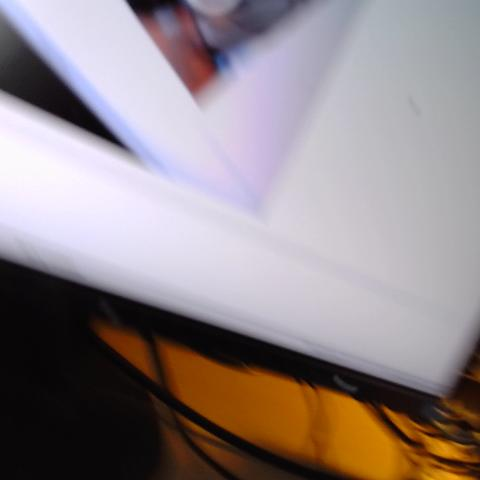

In [60]:
# Read the image and decode to a tensor
vc = cv2.VideoCapture(0)

display_id = None

if vc.isOpened(): # try to get the first frame
    try:
        for i in range(800):
            _, frame = vc.read()
            
            # Convert the image from OpenCV BGR format to matplotlib RGB format
            # to display the image
            img_rgb = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
            crop_size = min(img_rgb.size)
            scale = crop_size / 600

            # crop to square and resize for model input
            img_cropped = img_rgb.crop(((img_rgb.size[0]-crop_size)/2, (img_rgb.size[1]-crop_size)/2, (img_rgb.size[0]-crop_size)/2 + crop_size, (img_rgb.size[1]-crop_size)/2 + crop_size))
            img_resized = img_cropped.copy()
            img_resized.thumbnail((FRAME_SIZE_MODEL, FRAME_SIZE_MODEL), Image.ANTIALIAS)

            #img_resized = image. cv2.resize(img_rgb,(FRAME_SIZE_MODEL, FRAME_SIZE_MODEL))

            #Preprocess the image to required size and cast
            input_tensor= np.array(np.expand_dims(np.asarray(img_resized),0), dtype=np.uint8)
            input_index = interpreter.get_input_details()[0]["index"]            

            # Set input data
            interpreter.set_tensor(input_index, input_tensor)

            # Run the inference
            interpreter.invoke()
            output_details = interpreter.get_output_details()

            # location is [top, left, bottom, right] relative (0..1) to input dimensions
            location = np.squeeze(interpreter.get_tensor(output_details[0]['index']))
            category = np.squeeze(interpreter.get_tensor(output_details[1]['index']))
            score = np.squeeze(interpreter.get_tensor(output_details[2]['index']))

            # make a blank image for the text, initialized to transparent text color
            canvas = Image.new("RGBA", img_cropped.size, (255,255,255,0))

            # get a font
            fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeSans.ttf", int(26 * scale))
            # get a drawing context
            d = ImageDraw.Draw(canvas)

            outline_width = int(5*scale)

            for i in range(10):
                if score[i] > 0.6:
                    class_text = '{} {:.0f}%'.format(labels[int(category[i])], score[i]*100) 

                    # Image needs [left, top, right, bottom]
                    rect = np.array([location[i][1], location[i][0], location[i][3], location[i][2]]) * crop_size

                    # draw text, half opacity
                    text_dim = d.textsize(class_text, font=fnt)
                    bbox = ( rect[0] + outline_width, rect[1], rect[0] + text_dim[0] + outline_width, rect[1] + text_dim[1] + outline_width)

                    # draw elements
                    d.rectangle(bbox, fill=(0,0,0,64))
                    d.rectangle(rect, outline=(0,0,255,128), width=outline_width)
                    d.text(( rect[0] + outline_width, rect[1] + outline_width), class_text, font=fnt, fill=(255,255,255,255))

            # Create composize image with canvas
            composite = Image.alpha_composite(img_cropped.convert("RGBA"), canvas).convert("RGB")
            
            if display_id is not None:
                showarray(composite, display_id)
            else:
                display_id = showarray(composite).display_id
                
            # Display the frame info until new frame is available
            IPython.display.clear_output(wait=True)
    finally:
        vc.release()
else:
    is_capturing = False
    print("Camera not found!")